# Install and import libraries

In [ ]:
## INSTALL LIBRARIES IF REQUIRED 

!pip install viennarna
!pip install Bio 
!pip install lazypredict

In [1]:
## IMPORT LIBRARIES 

import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import webbrowser
from Bio.Seq import Seq
import re
from Bio.SeqUtils import MeltingTemp as mt
from Bio.SeqUtils import gc_fraction

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, average_precision_score, roc_auc_score, precision_recall_curve, auc, accuracy_score, f1_score, confusion_matrix, classification_report


# Feature engineering

In [3]:
# read in validation sequences and store as a df
sequence_df = pd.read_excel("384_sequences_for_validation.xlsx", header = 1, 
                            keep_default_na = False)
sequence_df.head()

# create a copy
sequence_df_features = sequence_df.copy()

# drop TM1, TM2, and Bonds columns (will be re-calculated)
sequence_df_features = sequence_df_features.drop(columns = ['TM1', 'TM2', 'Bonds'])

## Calculate no. of bonds formed in secondary structure and minimum free energy (MFE)

In [4]:
# define function to calculate bonds and MFE
def calculate_bonds_mfe(dna_sequence):

    # predict secondary structure and calculate bonds and MFE
    fold_comp = RNA.fold_compound(dna_sequence)
    structure, mfe = fold_comp.mfe()  # get secondary structure and MFE

    num_bonds = structure.count("(")  # count bonds

    return num_bonds, mfe  # return number of bonds and mfe 

# apply function to each sequence and store results in new columns
sequence_df_features[["SS_bonds", "MFE"]] = sequence_df_features["Template_Sequence"].apply(
    lambda seq: pd.Series(calculate_bonds_mfe(seq)))

# view the df
sequence_df_features

,ID,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE
0,1,CCTACGACTGAACAGACTCTCCTACGACTG,CI,12.6,16.6,4.0,0.0,0.0
1,2,CCTACGACTTAACAGACTCTCCTACGACTT,CI,16.3,21.4,5.1,0.0,0.0
2,3,CCTACGACGGAACAGACTCTCCTACGACGG,CI,15.4,16.5,1.2,7.0,-3.6
3,4,CCTACGAGTGAACAGACTCTCCTACGAGTG,CIII,17.8,17.8,0.1,4.0,-4.2
4,5,CCTACGGCTGAACAGACTCTCCTACGGCTG,CIII,12.5,12.0,-0.5,8.0,-6.1
...,...,...,...,...,...,...,...,...
379,380,GTAGGCGATGATGAGACTCTGTAGGCGATG,CI,9.0,11.1,2.2,4.0,-0.4
380,381,TCATGGACATCTGCGACTCTTCATGGACAT,"NR,NA,LA",0.0,0.0,0.0,7.0,-3.4
381,382,GCGTTCTAACACGCGACTCTGCGTTCTAAC,"NA,LA",0.0,0.0,0.0,4.0,-4.4
382,383,ACCAAAAGGCTAGCGACTCTACCAAAAGGC,CII,30.3,27.0,-3.2,7.0,-2.0


## Calculate number of bonds formed during self-hybridisation

In [5]:
# define function to count bonds formed during self-hybridisation
def count_hybridisation_bonds(sequence):
    seq = Seq(sequence)    # convert sequence into Biopython Seq object 
    rev_comp = seq.reverse_complement()   # identify reverse complement 

    # count hydrogen bonds
    bond_count = 0
    for a, b in zip(seq, rev_comp):
        if (a, b) in [('A', 'T'), ('T', 'A')]:
            bond_count += 2  # A-T has 2 H bonds
        elif (a, b) in [('G', 'C'), ('C', 'G')]:
            bond_count += 3  # G-C has 3 H bonds
    
    return bond_count

# apply function to each row and store results in new column 
sequence_df_features["SH_bonds"] = sequence_df_features["Template_Sequence"].apply(count_hybridisation_bonds)

# view the df
sequence_df_features

,ID,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE,SH_bonds
0,1,CCTACGACTGAACAGACTCTCCTACGACTG,CI,12.6,16.6,4.0,0.0,0.0,8
1,2,CCTACGACTTAACAGACTCTCCTACGACTT,CI,16.3,21.4,5.1,0.0,0.0,8
2,3,CCTACGACGGAACAGACTCTCCTACGACGG,CI,15.4,16.5,1.2,7.0,-3.6,8
3,4,CCTACGAGTGAACAGACTCTCCTACGAGTG,CIII,17.8,17.8,0.1,4.0,-4.2,8
4,5,CCTACGGCTGAACAGACTCTCCTACGGCTG,CIII,12.5,12.0,-0.5,8.0,-6.1,0
...,...,...,...,...,...,...,...,...,...
379,380,GTAGGCGATGATGAGACTCTGTAGGCGATG,CI,9.0,11.1,2.2,4.0,-0.4,40
380,381,TCATGGACATCTGCGACTCTTCATGGACAT,"NR,NA,LA",0.0,0.0,0.0,7.0,-3.4,26
381,382,GCGTTCTAACACGCGACTCTGCGTTCTAAC,"NA,LA",0.0,0.0,0.0,4.0,-4.4,20
382,383,ACCAAAAGGCTAGCGACTCTACCAAAAGGC,CII,30.3,27.0,-3.2,7.0,-2.0,26


## Calculate max homopolymer length

In [6]:
# define function to calculate max homopolymer length 
def max_homopolymer_length(dna_sequence):
    
    # find all homopolymers
    homopolymer_matches = re.findall(r'(A+|T+|C+|G+)', dna_sequence)
    
    # find max homopolymer length 
    max_length = max(len(match) for match in homopolymer_matches) if homopolymer_matches else 0
    
    return max_length 

# apply function to dataframe and store results in new column 
sequence_df_features["Max_Homopolymer_Length"] = sequence_df_features["Template_Sequence"].apply(max_homopolymer_length)

# view the df
sequence_df_features

,ID,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE,SH_bonds,Max_Homopolymer_Length
0,1,CCTACGACTGAACAGACTCTCCTACGACTG,CI,12.6,16.6,4.0,0.0,0.0,8,2
1,2,CCTACGACTTAACAGACTCTCCTACGACTT,CI,16.3,21.4,5.1,0.0,0.0,8,2
2,3,CCTACGACGGAACAGACTCTCCTACGACGG,CI,15.4,16.5,1.2,7.0,-3.6,8,2
3,4,CCTACGAGTGAACAGACTCTCCTACGAGTG,CIII,17.8,17.8,0.1,4.0,-4.2,8,2
4,5,CCTACGGCTGAACAGACTCTCCTACGGCTG,CIII,12.5,12.0,-0.5,8.0,-6.1,0,2
...,...,...,...,...,...,...,...,...,...,...
379,380,GTAGGCGATGATGAGACTCTGTAGGCGATG,CI,9.0,11.1,2.2,4.0,-0.4,40,2
380,381,TCATGGACATCTGCGACTCTTCATGGACAT,"NR,NA,LA",0.0,0.0,0.0,7.0,-3.4,26,2
381,382,GCGTTCTAACACGCGACTCTGCGTTCTAAC,"NA,LA",0.0,0.0,0.0,4.0,-4.4,20,2
382,383,ACCAAAAGGCTAGCGACTCTACCAAAAGGC,CII,30.3,27.0,-3.2,7.0,-2.0,26,4


## Count number of palindromic sequences

In [7]:
# define function to calculate palindrome count 
def count_palindromes(dna_sequence, min_len = 4, max_len = 30):  
    
    # initialise counter
    palindromes = 0
    
    # loop over possible palindrome lengths 
    for length in range(min_len, max_len + 1): 
        
        # iterate over all possible sub-sequences 
        for i in range(len(dna_sequence) - length + 1):
            subsequence = dna_sequence[i:i + length]
            reverse_complement = str(Seq(subsequence).reverse_complement())
            if subsequence == reverse_complement:
                palindromes += 1
                
    return palindromes 

# apply function to dataframe and store results in new column 
sequence_df_features["Palindrome_Count"] = sequence_df_features["Template_Sequence"].apply(count_palindromes)

# view the df
sequence_df_features

,ID,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE,SH_bonds,Max_Homopolymer_Length,Palindrome_Count
0,1,CCTACGACTGAACAGACTCTCCTACGACTG,CI,12.6,16.6,4.0,0.0,0.0,8,2,0
1,2,CCTACGACTTAACAGACTCTCCTACGACTT,CI,16.3,21.4,5.1,0.0,0.0,8,2,1
2,3,CCTACGACGGAACAGACTCTCCTACGACGG,CI,15.4,16.5,1.2,7.0,-3.6,8,2,0
3,4,CCTACGAGTGAACAGACTCTCCTACGAGTG,CIII,17.8,17.8,0.1,4.0,-4.2,8,2,0
4,5,CCTACGGCTGAACAGACTCTCCTACGGCTG,CIII,12.5,12.0,-0.5,8.0,-6.1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
379,380,GTAGGCGATGATGAGACTCTGTAGGCGATG,CI,9.0,11.1,2.2,4.0,-0.4,40,2,0
380,381,TCATGGACATCTGCGACTCTTCATGGACAT,"NR,NA,LA",0.0,0.0,0.0,7.0,-3.4,26,2,2
381,382,GCGTTCTAACACGCGACTCTGCGTTCTAAC,"NA,LA",0.0,0.0,0.0,4.0,-4.4,20,2,1
382,383,ACCAAAAGGCTAGCGACTCTACCAAAAGGC,CII,30.3,27.0,-3.2,7.0,-2.0,26,4,2


## Calculate melting temperatures 
- TM1: template-trigger melting temp in Celsius
- TM2: template-template melting temp in Celsius

In [8]:
# define function to calculate melting temperatures

def calculate_tm(seq):
    dna_seq = Seq(seq)  # convert the sequence into a Biopython Seq object
    
    # calculate template-template Tm 
    tm2_value = round(mt.Tm_NN(dna_seq, Na=1000, Mg=0), 1)

    # calculate template-trigger Tm
    tm1_value = round(mt.Tm_NN(dna_seq, Na=1000, Mg=0, dnac1=50e-9, dnac2=50e-9), 1)
    
    return tm1_value, tm2_value

# apply the function to each sequence and assign results to new columns
sequence_df_features[['TM1', 'TM2']] = sequence_df_features['Template_Sequence'].apply(lambda seq: pd.Series(calculate_tm(seq)))

# view the df
sequence_df_features

,ID,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE,SH_bonds,Max_Homopolymer_Length,Palindrome_Count,TM1,TM2
0,1,CCTACGACTGAACAGACTCTCCTACGACTG,CI,12.6,16.6,4.0,0.0,0.0,8,2,0,57.3,76.5
1,2,CCTACGACTTAACAGACTCTCCTACGACTT,CI,16.3,21.4,5.1,0.0,0.0,8,2,1,55.2,74.6
2,3,CCTACGACGGAACAGACTCTCCTACGACGG,CI,15.4,16.5,1.2,7.0,-3.6,8,2,0,60.5,79.8
3,4,CCTACGAGTGAACAGACTCTCCTACGAGTG,CIII,17.8,17.8,0.1,4.0,-4.2,8,2,0,57.3,76.5
4,5,CCTACGGCTGAACAGACTCTCCTACGGCTG,CIII,12.5,12.0,-0.5,8.0,-6.1,0,2,0,60.9,80.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,380,GTAGGCGATGATGAGACTCTGTAGGCGATG,CI,9.0,11.1,2.2,4.0,-0.4,40,2,0,58.1,77.3
380,381,TCATGGACATCTGCGACTCTTCATGGACAT,"NR,NA,LA",0.0,0.0,0.0,7.0,-3.4,26,2,2,57.6,77.3
381,382,GCGTTCTAACACGCGACTCTGCGTTCTAAC,"NA,LA",0.0,0.0,0.0,4.0,-4.4,20,2,1,59.9,78.7
382,383,ACCAAAAGGCTAGCGACTCTACCAAAAGGC,CII,30.3,27.0,-3.2,7.0,-2.0,26,4,2,58.8,78.4


## Calculate GC and AT content 

In [9]:
# define function to calculate GC and AT content 

def calculate_gc_at_content(seq):
    
    sequence = Seq(seq)  # store sequence as a Bioseq object 
    
    gc_content = round(gc_fraction(sequence) * 100, 1)    # calculate GC content
     
    at_content = 100 - gc_content    # calculate AT content 
    
    return gc_content, at_content

# apply the function to each sequence and assign results to new columns
sequence_df_features[['GC_content', 'AT_content']] = sequence_df_features['Template_Sequence'].apply(calculate_gc_at_content).apply(pd.Series)

# view the df
sequence_df_features

,ID,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE,SH_bonds,Max_Homopolymer_Length,Palindrome_Count,TM1,TM2,GC_content,AT_content
0,1,CCTACGACTGAACAGACTCTCCTACGACTG,CI,12.6,16.6,4.0,0.0,0.0,8,2,0,57.3,76.5,53.3,46.7
1,2,CCTACGACTTAACAGACTCTCCTACGACTT,CI,16.3,21.4,5.1,0.0,0.0,8,2,1,55.2,74.6,46.7,53.3
2,3,CCTACGACGGAACAGACTCTCCTACGACGG,CI,15.4,16.5,1.2,7.0,-3.6,8,2,0,60.5,79.8,60.0,40.0
3,4,CCTACGAGTGAACAGACTCTCCTACGAGTG,CIII,17.8,17.8,0.1,4.0,-4.2,8,2,0,57.3,76.5,53.3,46.7
4,5,CCTACGGCTGAACAGACTCTCCTACGGCTG,CIII,12.5,12.0,-0.5,8.0,-6.1,0,2,0,60.9,80.4,60.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,380,GTAGGCGATGATGAGACTCTGTAGGCGATG,CI,9.0,11.1,2.2,4.0,-0.4,40,2,0,58.1,77.3,53.3,46.7
380,381,TCATGGACATCTGCGACTCTTCATGGACAT,"NR,NA,LA",0.0,0.0,0.0,7.0,-3.4,26,2,2,57.6,77.3,46.7,53.3
381,382,GCGTTCTAACACGCGACTCTGCGTTCTAAC,"NA,LA",0.0,0.0,0.0,4.0,-4.4,20,2,1,59.9,78.7,53.3,46.7
382,383,ACCAAAAGGCTAGCGACTCTACCAAAAGGC,CII,30.3,27.0,-3.2,7.0,-2.0,26,4,2,58.8,78.4,50.0,50.0


## Calculate sequence length 

In [10]:
# define function to calculate sequence length 
def calculate_sequence_length(seq):
    
    return len(seq)

# apply function to each row and add sequence length to new column
sequence_df_features['Sequence_Length'] = sequence_df_features['Template_Sequence'].apply(calculate_sequence_length)

# view the df 
sequence_df_features

,ID,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE,SH_bonds,Max_Homopolymer_Length,Palindrome_Count,TM1,TM2,GC_content,AT_content,Sequence_Length
0,1,CCTACGACTGAACAGACTCTCCTACGACTG,CI,12.6,16.6,4.0,0.0,0.0,8,2,0,57.3,76.5,53.3,46.7,30
1,2,CCTACGACTTAACAGACTCTCCTACGACTT,CI,16.3,21.4,5.1,0.0,0.0,8,2,1,55.2,74.6,46.7,53.3,30
2,3,CCTACGACGGAACAGACTCTCCTACGACGG,CI,15.4,16.5,1.2,7.0,-3.6,8,2,0,60.5,79.8,60.0,40.0,30
3,4,CCTACGAGTGAACAGACTCTCCTACGAGTG,CIII,17.8,17.8,0.1,4.0,-4.2,8,2,0,57.3,76.5,53.3,46.7,30
4,5,CCTACGGCTGAACAGACTCTCCTACGGCTG,CIII,12.5,12.0,-0.5,8.0,-6.1,0,2,0,60.9,80.4,60.0,40.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,380,GTAGGCGATGATGAGACTCTGTAGGCGATG,CI,9.0,11.1,2.2,4.0,-0.4,40,2,0,58.1,77.3,53.3,46.7,30
380,381,TCATGGACATCTGCGACTCTTCATGGACAT,"NR,NA,LA",0.0,0.0,0.0,7.0,-3.4,26,2,2,57.6,77.3,46.7,53.3,30
381,382,GCGTTCTAACACGCGACTCTGCGTTCTAAC,"NA,LA",0.0,0.0,0.0,4.0,-4.4,20,2,1,59.9,78.7,53.3,46.7,30
382,383,ACCAAAAGGCTAGCGACTCTACCAAAAGGC,CII,30.3,27.0,-3.2,7.0,-2.0,26,4,2,58.8,78.4,50.0,50.0,30


## Calculate nucleotide composition 

In [11]:
# define function to calculate nucleotide composition 
def nucleotide_comp(seq):
    
    # count number of each base (A, C, T, G) in the sequence 
    a_count = seq.count('A')
    c_count = seq.count('C')
    g_count = seq.count('G')
    t_count = seq.count('T')
    
    return a_count, c_count, g_count, t_count

# apply the function to each row in the dataframe
sequence_df_features[['A_count', 'C_count', 'G_count', 'T_count']] = sequence_df_features['Template_Sequence'].apply(
    lambda seq: pd.Series(nucleotide_comp(seq))
)

# view the df
sequence_df_features

,ID,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE,SH_bonds,Max_Homopolymer_Length,Palindrome_Count,TM1,TM2,GC_content,AT_content,Sequence_Length,A_count,C_count,G_count,T_count
0,1,CCTACGACTGAACAGACTCTCCTACGACTG,CI,12.6,16.6,4.0,0.0,0.0,8,2,0,57.3,76.5,53.3,46.7,30,8,11,5,6
1,2,CCTACGACTTAACAGACTCTCCTACGACTT,CI,16.3,21.4,5.1,0.0,0.0,8,2,1,55.2,74.6,46.7,53.3,30,8,11,3,8
2,3,CCTACGACGGAACAGACTCTCCTACGACGG,CI,15.4,16.5,1.2,7.0,-3.6,8,2,0,60.5,79.8,60.0,40.0,30,8,11,7,4
3,4,CCTACGAGTGAACAGACTCTCCTACGAGTG,CIII,17.8,17.8,0.1,4.0,-4.2,8,2,0,57.3,76.5,53.3,46.7,30,8,9,7,6
4,5,CCTACGGCTGAACAGACTCTCCTACGGCTG,CIII,12.5,12.0,-0.5,8.0,-6.1,0,2,0,60.9,80.4,60.0,40.0,30,6,11,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,380,GTAGGCGATGATGAGACTCTGTAGGCGATG,CI,9.0,11.1,2.2,4.0,-0.4,40,2,0,58.1,77.3,53.3,46.7,30,7,4,12,7
380,381,TCATGGACATCTGCGACTCTTCATGGACAT,"NR,NA,LA",0.0,0.0,0.0,7.0,-3.4,26,2,2,57.6,77.3,46.7,53.3,30,7,8,6,9
381,382,GCGTTCTAACACGCGACTCTGCGTTCTAAC,"NA,LA",0.0,0.0,0.0,4.0,-4.4,20,2,1,59.9,78.7,53.3,46.7,30,6,10,6,8
382,383,ACCAAAAGGCTAGCGACTCTACCAAAAGGC,CII,30.3,27.0,-3.2,7.0,-2.0,26,4,2,58.8,78.4,50.0,50.0,30,12,9,6,3


## Create features for each nucleotide position

In [12]:
# create new columns for nucleotides 1 to 30
for i in range(1, 31):  
    sequence_df_features[f'position_{i}'] = None  # initialise new column

# iterate through each row and assign nucleotides at each position
for index, row in sequence_df_features.iterrows():
    sequence = row['Template_Sequence']
    
    # iterate through positions 1 to 30 
    for i in range(1, 31):  
        if i <= len(sequence):  
            sequence_df_features.at[index, f'position_{i}'] = sequence[i-1]  # insert nucleotide at current position
        else:
            sequence_df_features.at[index, f'position_{i}'] = None  # if the sequence is shorter, leave as None

# view the df 
sequence_df_features

,ID,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE,SH_bonds,Max_Homopolymer_Length,...,position_21,position_22,position_23,position_24,position_25,position_26,position_27,position_28,position_29,position_30
0,1,CCTACGACTGAACAGACTCTCCTACGACTG,CI,12.6,16.6,4.0,0.0,0.0,8,2,...,C,C,T,A,C,G,A,C,T,G
1,2,CCTACGACTTAACAGACTCTCCTACGACTT,CI,16.3,21.4,5.1,0.0,0.0,8,2,...,C,C,T,A,C,G,A,C,T,T
2,3,CCTACGACGGAACAGACTCTCCTACGACGG,CI,15.4,16.5,1.2,7.0,-3.6,8,2,...,C,C,T,A,C,G,A,C,G,G
3,4,CCTACGAGTGAACAGACTCTCCTACGAGTG,CIII,17.8,17.8,0.1,4.0,-4.2,8,2,...,C,C,T,A,C,G,A,G,T,G
4,5,CCTACGGCTGAACAGACTCTCCTACGGCTG,CIII,12.5,12.0,-0.5,8.0,-6.1,0,2,...,C,C,T,A,C,G,G,C,T,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,380,GTAGGCGATGATGAGACTCTGTAGGCGATG,CI,9.0,11.1,2.2,4.0,-0.4,40,2,...,G,T,A,G,G,C,G,A,T,G
380,381,TCATGGACATCTGCGACTCTTCATGGACAT,"NR,NA,LA",0.0,0.0,0.0,7.0,-3.4,26,2,...,T,C,A,T,G,G,A,C,A,T
381,382,GCGTTCTAACACGCGACTCTGCGTTCTAAC,"NA,LA",0.0,0.0,0.0,4.0,-4.4,20,2,...,G,C,G,T,T,C,T,A,A,C
382,383,ACCAAAAGGCTAGCGACTCTACCAAAAGGC,CII,30.3,27.0,-3.2,7.0,-2.0,26,4,...,A,C,C,A,A,A,A,G,G,C


In [13]:
## DROP COLUMNS WHICH ARE NO LONGER NEEDED

filtered_df = sequence_df_features.copy()

# filter out sequences which are not CI, CII, or CIII
filtered_df = filtered_df[filtered_df['Results'].isin(['CI', 'CII', 'CIII'])]

# drop positions 15-19 
filtered_df = filtered_df.drop(filtered_df.columns[34:39], axis = 1)

# drop id column
filtered_df = filtered_df.drop(filtered_df.columns[0], axis = 1)

# view the df
filtered_df

,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE,SH_bonds,Max_Homopolymer_Length,Palindrome_Count,...,position_21,position_22,position_23,position_24,position_25,position_26,position_27,position_28,position_29,position_30
0,CCTACGACTGAACAGACTCTCCTACGACTG,CI,12.6,16.6,4.0,0.0,0.0,8,2,0,...,C,C,T,A,C,G,A,C,T,G
1,CCTACGACTTAACAGACTCTCCTACGACTT,CI,16.3,21.4,5.1,0.0,0.0,8,2,1,...,C,C,T,A,C,G,A,C,T,T
2,CCTACGACGGAACAGACTCTCCTACGACGG,CI,15.4,16.5,1.2,7.0,-3.6,8,2,0,...,C,C,T,A,C,G,A,C,G,G
3,CCTACGAGTGAACAGACTCTCCTACGAGTG,CIII,17.8,17.8,0.1,4.0,-4.2,8,2,0,...,C,C,T,A,C,G,A,G,T,G
4,CCTACGGCTGAACAGACTCTCCTACGGCTG,CIII,12.5,12.0,-0.5,8.0,-6.1,0,2,0,...,C,C,T,A,C,G,G,C,T,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,TAACTACGGCGGTTGACTCTTAACTACGGC,CII,26.5,19.8,-6.7,8.0,-3.7,16,2,1,...,T,A,A,C,T,A,C,G,G,C
378,ATTAGCCAGCCGATGACTCTATTAGCCAGC,CIII,11.5,12.4,0.8,8.0,-3.0,0,2,0,...,A,T,T,A,G,C,C,A,G,C
379,GTAGGCGATGATGAGACTCTGTAGGCGATG,CI,9.0,11.1,2.2,4.0,-0.4,40,2,0,...,G,T,A,G,G,C,G,A,T,G
382,ACCAAAAGGCTAGCGACTCTACCAAAAGGC,CII,30.3,27.0,-3.2,7.0,-2.0,26,4,2,...,A,C,C,A,A,A,A,G,G,C


## Save as a csv file 

In [14]:
# save as csv
filtered_df.to_csv("filtered_df.csv", index = False)

# Building a machine learning classifier 
- predict classes I, II, and III
- identify important features

In [15]:
## SPLIT INTO TRAIN AND TEST SET 

# stratify split based on class ('Results')
train_df, test_df = train_test_split(filtered_df, test_size = 0.2, random_state = 22, stratify = filtered_df['Results'])

print(f"Training set size: {train_df.shape[0]} rows")

print(train_df.shape)
print(test_df.shape)
print(train_df.columns)

Training set size: 212 rows
(212, 44)
(53, 44)
Index(['Template_Sequence', 'Results', 'P90', 'N10', 'Diff', 'SS_bonds', 'MFE',
       'SH_bonds', 'Max_Homopolymer_Length', 'Palindrome_Count', 'TM1', 'TM2',
       'GC_content', 'AT_content', 'Sequence_Length', 'A_count', 'C_count',
       'G_count', 'T_count', 'position_1', 'position_2', 'position_3',
       'position_4', 'position_5', 'position_6', 'position_7', 'position_8',
       'position_9', 'position_10', 'position_11', 'position_12',
       'position_13', 'position_14', 'position_20', 'position_21',
       'position_22', 'position_23', 'position_24', 'position_25',
       'position_26', 'position_27', 'position_28', 'position_29',
       'position_30'],
      dtype='object')


## Data processing

In [16]:
## CREATE A PIPELINE TO TRANSFORM FEATURES

# define numeric features 
numeric_features = ['P90', 'N10', 'Diff', 'SS_bonds', 'MFE', 'SH_bonds', 'Max_Homopolymer_Length',
                    'Palindrome_Count', 'TM1', 'TM2', 'GC_content', 'AT_content', 'Sequence_Length',
                    'A_count', 'C_count', 'G_count', 'T_count']

# scale numeric features 
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])   # use robust scaler as not all features are normally distributed 

# define categorical features 
categorical_features = [f'position_{i}' for i in range(1, 31) if i < 15 or i > 19]

# onehot encode categorical features 
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [17]:
## APPLY PRE-PROCESSOR TO TRAIN AND TEST SETS SEPARATELY (EXCLUDE ID, TEMPLATE_SEQUENCE AND RESULTS COLUMNS)

clf = Pipeline(steps=[('preprocessor', preprocessor)])

# select columns to be transformed (exclude Template_Sequence and Results)
exclude_columns_train = train_df.iloc[:, :2]
transform_columns_train = train_df.iloc[:, 2:]
transformed_train = clf.fit_transform(transform_columns_train)

exclude_columns_test = test_df.iloc[:, :2]
transform_columns_test = test_df.iloc[:, 2:]
transformed_test = clf.fit_transform(transform_columns_test)

# apply preprocessor to transform columns in training data 
transformed_train_df = pd.DataFrame(transformed_train)

# apply preprocessor to transform columns in testing data 
transformed_test_df = pd.DataFrame(transformed_test)

In [18]:
transformed_train_df

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,0.000000,0.021978,-0.044248,-0.666667,-0.460177,-0.555556,-1.0,-0.5,-0.361582,-0.446809,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.649057,-0.672527,0.061947,0.000000,0.601770,0.000000,0.0,-0.5,0.248588,0.106383,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.788679,1.191209,-1.920354,0.333333,0.035398,1.444444,0.0,0.5,0.022599,-0.042553,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-0.430189,-0.312088,0.274336,-1.333333,0.601770,0.000000,-1.0,-0.5,0.067797,0.042553,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.384906,0.021978,0.840708,-2.000000,1.026549,-0.222222,-1.0,0.5,0.474576,0.404255,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,0.611321,1.120879,0.716814,-1.000000,0.955752,1.333333,1.0,-0.5,1.853107,1.808511,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
208,-0.626415,-0.523077,0.327434,-0.333333,-0.283186,0.333333,0.0,-0.5,-0.610169,-0.510638,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
209,-0.769811,-0.751648,0.185841,0.333333,-0.070796,0.000000,-1.0,-0.5,0.813559,0.723404,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
210,-0.686792,-0.619780,0.256637,-0.666667,0.070796,-0.777778,0.0,0.5,-0.090395,-0.085106,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [19]:
## ADD TEMPLATE_SEQUENCE AND RESULTS COLUMNS 

# reset index - train 
exclude_columns_train = exclude_columns_train.reset_index(drop = True)
transformed_train_df = transformed_train_df.reset_index(drop = True)

# add first two columns back in - train
new_train_df = pd.concat([exclude_columns_train, transformed_train_df], axis = 1)

# reset index - test
exclude_columns_test = exclude_columns_test.reset_index(drop = True)
transformed_test_df = transformed_test_df.reset_index(drop = True)

# add first two columns back in - test
new_test_df = pd.concat([exclude_columns_test, transformed_test_df], axis = 1)


In [20]:
## SET COLUMN NAMES 

# set column names - train 
train_categorical_colnames = clf['preprocessor'].transformers_[1][1]['onehot']\
    .get_feature_names_out(categorical_features)
new_train_df.columns = list(exclude_columns_train.columns) + numeric_features + list(train_categorical_colnames)

# set column names - test 
test_categorical_colnames = clf['preprocessor'].transformers_[1][1]['onehot']\
    .get_feature_names_out(categorical_features)
new_test_df.columns = list(exclude_columns_test.columns) + numeric_features + list(test_categorical_colnames)

new_train_df

,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE,SH_bonds,Max_Homopolymer_Length,Palindrome_Count,...,position_28_G,position_28_T,position_29_A,position_29_C,position_29_G,position_29_T,position_30_A,position_30_C,position_30_G,position_30_T
0,CCTACGAGTGAACAGACTCTCCTACGAGTG,CIII,0.000000,0.021978,-0.044248,-0.666667,-0.460177,-0.555556,-1.0,-0.5,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,GCTGACAAAGGTGCGACTCTGCTGACAAAG,CIII,-0.649057,-0.672527,0.061947,0.000000,0.601770,0.000000,0.0,-0.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,CGTACCAAGAACCCGACTCTCGTACCAAGA,CII,1.788679,1.191209,-1.920354,0.333333,0.035398,1.444444,0.0,0.5,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,CCGCTATTCTGCCAGACTCTCCGCTATTCT,CI,-0.430189,-0.312088,0.274336,-1.333333,0.601770,0.000000,-1.0,-0.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,GATGACCGCCTCTAGACTCTGATGACCGCC,CI,-0.384906,0.021978,0.840708,-2.000000,1.026549,-0.222222,-1.0,0.5,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,CCCGCCTTCCCCGAGACTCTCCCGCCTTCC,CIII,0.611321,1.120879,0.716814,-1.000000,0.955752,1.333333,1.0,-0.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
208,ATGTGGGTTTGATGGACTCTATGTGGGTTT,CI,-0.626415,-0.523077,0.327434,-0.333333,-0.283186,0.333333,0.0,-0.5,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
209,CTTGTGCTGGTGGCGACTCTCTTGTGCTGG,CI,-0.769811,-0.751648,0.185841,0.333333,-0.070796,0.000000,-1.0,-0.5,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
210,ATGGGTACGGTTGAGACTCTATGGGTACGG,CI,-0.686792,-0.619780,0.256637,-0.666667,0.070796,-0.777778,0.0,0.5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [21]:
# check results columns

print(new_train_df['Results'].unique())
print(new_test_df['Results'].unique())

['CIII' 'CII' 'CI']
['CIII' 'CI' 'CII']


In [22]:
## ORDINAL ENCODING FOR TARGET (RESULTS COLUMNS)

# define order - II (poor), III (intermediate), I (good)
class_order = [["CII", "CIII", "CI"]] 

ordinal_encoder = OrdinalEncoder(categories = class_order)

# apply ordinal encoding to target column 
new_train_df['Results'] = ordinal_encoder.fit_transform(new_train_df[["Results"]])
new_test_df['Results'] = ordinal_encoder.fit_transform(new_test_df[['Results']])
new_train_df

,Template_Sequence,Results,P90,N10,Diff,SS_bonds,MFE,SH_bonds,Max_Homopolymer_Length,Palindrome_Count,...,position_28_G,position_28_T,position_29_A,position_29_C,position_29_G,position_29_T,position_30_A,position_30_C,position_30_G,position_30_T
0,CCTACGAGTGAACAGACTCTCCTACGAGTG,1.0,0.000000,0.021978,-0.044248,-0.666667,-0.460177,-0.555556,-1.0,-0.5,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,GCTGACAAAGGTGCGACTCTGCTGACAAAG,1.0,-0.649057,-0.672527,0.061947,0.000000,0.601770,0.000000,0.0,-0.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,CGTACCAAGAACCCGACTCTCGTACCAAGA,0.0,1.788679,1.191209,-1.920354,0.333333,0.035398,1.444444,0.0,0.5,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,CCGCTATTCTGCCAGACTCTCCGCTATTCT,2.0,-0.430189,-0.312088,0.274336,-1.333333,0.601770,0.000000,-1.0,-0.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,GATGACCGCCTCTAGACTCTGATGACCGCC,2.0,-0.384906,0.021978,0.840708,-2.000000,1.026549,-0.222222,-1.0,0.5,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,CCCGCCTTCCCCGAGACTCTCCCGCCTTCC,1.0,0.611321,1.120879,0.716814,-1.000000,0.955752,1.333333,1.0,-0.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
208,ATGTGGGTTTGATGGACTCTATGTGGGTTT,2.0,-0.626415,-0.523077,0.327434,-0.333333,-0.283186,0.333333,0.0,-0.5,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
209,CTTGTGCTGGTGGCGACTCTCTTGTGCTGG,2.0,-0.769811,-0.751648,0.185841,0.333333,-0.070796,0.000000,-1.0,-0.5,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
210,ATGGGTACGGTTGAGACTCTATGGGTACGG,2.0,-0.686792,-0.619780,0.256637,-0.666667,0.070796,-0.777778,0.0,0.5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# define features and target
X_train = new_train_df.iloc[:, 2:]
y_train = new_train_df.iloc[:, 1]
print(X_train)
print(y_train)

X_test = new_test_df.iloc[:, 2:]
y_test = new_test_df.iloc[:, 1]

          P90       N10      Diff  SS_bonds       MFE  SH_bonds  \
0    0.000000  0.021978 -0.044248 -0.666667 -0.460177 -0.555556   
1   -0.649057 -0.672527  0.061947  0.000000  0.601770  0.000000   
2    1.788679  1.191209 -1.920354  0.333333  0.035398  1.444444   
3   -0.430189 -0.312088  0.274336 -1.333333  0.601770  0.000000   
4   -0.384906  0.021978  0.840708 -2.000000  1.026549 -0.222222   
..        ...       ...       ...       ...       ...       ...   
207  0.611321  1.120879  0.716814 -1.000000  0.955752  1.333333   
208 -0.626415 -0.523077  0.327434 -0.333333 -0.283186  0.333333   
209 -0.769811 -0.751648  0.185841  0.333333 -0.070796  0.000000   
210 -0.686792 -0.619780  0.256637 -0.666667  0.070796 -0.777778   
211 -0.060377 -0.496703 -0.964602  0.000000  0.814159  1.000000   

     Max_Homopolymer_Length  Palindrome_Count       TM1       TM2  ...  \
0                      -1.0              -0.5 -0.361582 -0.446809  ...   
1                       0.0              -0.5  

## Hyperparameter tuning

In [25]:
# initialise stratified K-fold for cross-validation
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 22)

# define parameters to tune 
param_grid = {
    'n_estimators': [50, 100, 200, 300],        # number of trees in the forest
    'max_depth': [3, 5, 7, 10, 12, 15, None],   # max. depth of each tree
    'min_samples_split': [2, 5, 10],            # min. number of samples needed to split a node
    'max_features': ['auto', 'sqrt', 'log2']    # how many features to consider for splitting 
}

# initialise a RandomForestClassifier 
rf = RandomForestClassifier(random_state = 22)

# initialise GridSearchCV to identify optimal hyperparameters
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = skf)

# fit GridSearchCV to training data 
grid_search.fit(X_train, y_train)

# obtain the best parameters 
best_params = grid_search.best_params_
print('Best parameters for RandomForestClassifier: ', best_params)
print('Best accuracy for RandomForestClassifier: ', grid_search.best_score_)


Best parameters for RandomForestClassifier:  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
Best accuracy for RandomForestClassifier:  0.8725359911406423


/usr/local/lib64/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
420 fits failed out of a total of 1260.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib64/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib64/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib64/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib64/python3.9/site-packages/sklear

In [26]:
# store the best performing RF model 
best_rf = RandomForestClassifier(**best_params, random_state = 22)

## Evaluating model performance

In [29]:
# define a function to evaluate model performance 
def model_eval(model, X_train, X_test, y_train, y_test):

    # fit model on entire training set 
    model_fit = model.fit(X_train, y_train) 

    # evaluate model on test set 
    y_pred = model.predict(X_test)  # predict target for X_test
    y_prob = model.predict_proba(X_test)   # extract predicted probabilities for all classes 

    # print confusion matrix
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    print()

    # print metrics
    print('Accuracy:', accuracy_score(y_test, y_pred))
        
    print('F1 Score (macro):', f1_score(y_test, y_pred, average = "macro"))

    print('ROC AUC (macro):', roc_auc_score(y_test, y_prob, multi_class = "ovr"))
    
    # compute PR AUC for each class 
    pr_auc_scores = []
     
    for i in range(y_prob.shape[1]):   # iterate over each class 
        precision, recall, _ = precision_recall_curve(y_test == i, y_prob[:, i])
        pr_auc_scores.append(auc(recall, precision))

    print('PR AUC (macro avg):', np.mean(pr_auc_scores))


In [30]:
# evaluate model performance 
model_eval(best_rf, X_train, X_test, y_train, y_test)

Confusion Matrix
[[13  3  0]
 [ 1 12  4]
 [ 0  3 17]]

Accuracy: 0.7924528301886793
F1 Score (macro): 0.7938830816879597
ROC AUC (macro): 0.9280620192384897
PR AUC (macro avg): 0.8701032421848263


In [31]:
## CALCULATE SPECIFICTY FOR EACH CLASS

# define function to calculate specificity 
def calculate_specificity(y_test, y_pred):
                          
    # obtain confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # initialise list to store specificity values for each class
    specificity_scores = []

    # iterate over each class
    for i in range(3):
        
        # calculate true negatives 
        true_negatives = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        
        # calculate false positives 
        false_positives = np.sum(cm[:, i]) - cm[i, i]
        
        # calculate specificity 
        specificity = true_negatives / (true_negatives + false_positives)
        specificity_scores.append(specificity)
    
    return specificity_scores

# fit model on training set 
model_fit = best_rf.fit(X_train, y_train) 

# evaluate model on test set 
y_pred = best_rf.predict(X_test)  # predict target for X_test
y_prob = best_rf.predict_proba(X_test)   # extract predicted probabilities for all classes 

specificities = calculate_specificity(y_test, y_pred)

# print specificities for classes I, III, and II
print("Specificities for each class:", specificities)


[[13  3  0]
 [ 1 12  4]
 [ 0  3 17]]
Specificities for each class: [0.972972972972973, 0.8333333333333334, 0.8787878787878788]


In [32]:
# define function to calculate sensitivity 
def calculate_sensitivity(y_test, y_pred):
    
    # obtain confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # create a list to store sensitivity values for each class
    sensitivity_scores = []

    # iterate over each class
    for i in range(3):
        
        # calculate true positives 
        true_positives = cm[i, i]

        # calculate false negatives 
        false_negatives = np.sum(cm[i, :]) - true_positives
        
        # calculate sensitivity
        sensitivity = true_positives / (true_positives + false_negatives)
        sensitivity_scores.append(sensitivity)
        
    return sensitivity_scores

sensitivities = calculate_sensitivity(y_test, y_pred)#

# print sensitivities for classes I, III, and II
print("Sensitivies for each class:", sensitivities)

Sensitivies for each class: [0.8125, 0.7058823529411765, 0.85]


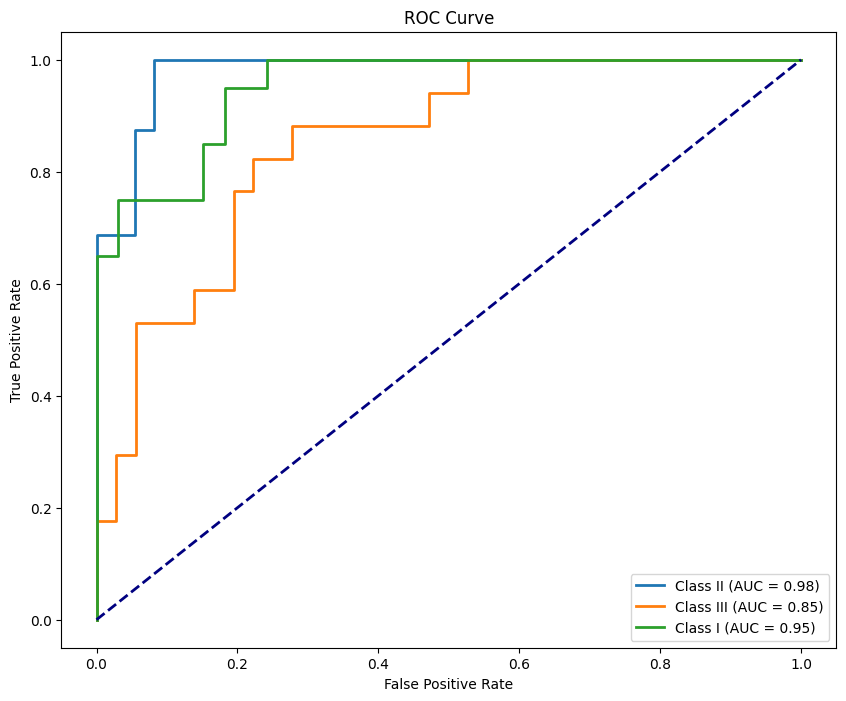

In [38]:
## PLOT ROC CURVE 

# fit the model 
best_rf.fit(X_train, y_train) 

# get predicted probabilities
y_prob = best_rf.predict_proba(X_test)

# binarise the true labels 
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  

# define number of classes 
n_classes = y_test_bin.shape[1]

# initialise plot
plt.figure(figsize=(10, 8))

# define custom class labels - II (poor), III (intermediate), I (good)
class_labels = {0: "II", 1: "III", 2: "I"}

# plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)

    # Apply the custom label mapping
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

# plot the diagonal 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# set axis labels, title, and legend 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# display plot 
plt.show()

## Calculate feature importance

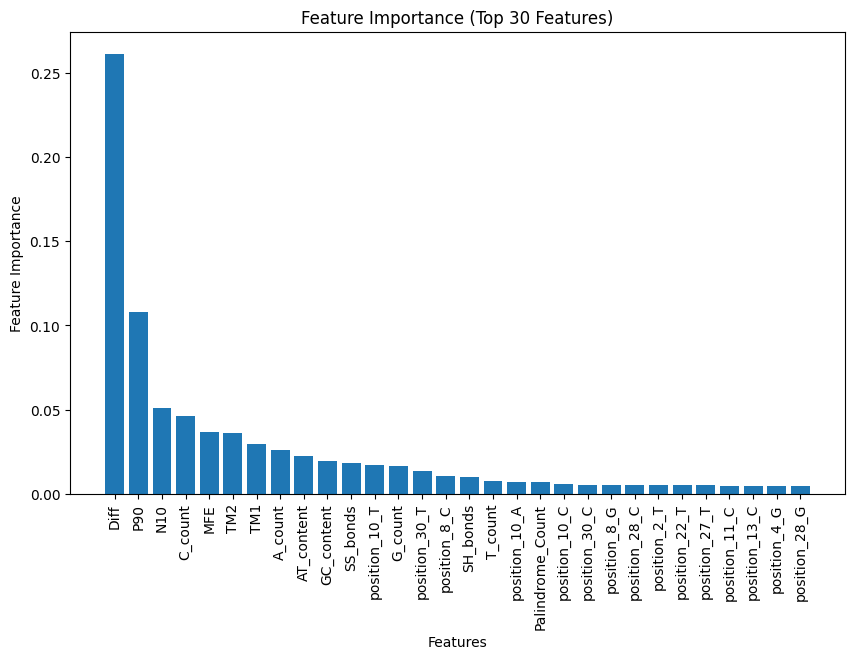

In [41]:
# fit model with best parameters
best_rf.fit(X_train, y_train)

# calculate feature importances 
importances = best_rf.feature_importances_
feature_importance_sorted_indices = np.argsort(importances)[::-1]
top_features = X_train.columns[feature_importance_sorted_indices]
top_importances = importances[feature_importance_sorted_indices]

# plot feature importance for top 30 features
plt.figure(figsize=(10,6))
plt.title(f'Feature Importance (Top 30 Features)')
plt.bar(range(30), top_importances[:30])
plt.xticks(range(30), top_features[:30], rotation = 90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.show()

# Random forest without P90, N10, and Diff

## Hyperparameter tuning

In [40]:
# initialise stratified K-fold for cross-validation
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 22)

# define parameters to tune 
param_grid = {
    'n_estimators': [50, 100, 200, 300], 
    'max_depth': [3, 5, 7, 10, 12, 15, None],
    'min_samples_split': [2, 5, 10], 
    'max_features': ['auto', 'sqrt', 'log2']
}

# initialise a RandomForestClassifier 
rf = RandomForestClassifier(random_state = 22)

# initialise GridSearchCV
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = skf)

# fit GridSearchCV
grid_search.fit(X_train.iloc[:, 3:], y_train)   # exclude P90, N10, Diff

# obtain the best parameters 
best_params = grid_search.best_params_
print('Best parameters for RandomForestClassifier: ', best_params)
print('Best accuracy for RandomForestClassifier: ', grid_search.best_score_)


/usr/local/lib64/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
420 fits failed out of a total of 1260.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib64/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib64/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib64/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib64/python3.9/site-packages/sklear

Best parameters for RandomForestClassifier:  {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 300}
Best accuracy for RandomForestClassifier:  0.5283499446290143


## Model evaluation

In [42]:
# store best rf model
best_rf2 = RandomForestClassifier(**best_params, random_state = 22)

# evaluate model performance when P90, N10, and Diff have been excluded 
model_eval(best_rf2, X_train.iloc[:, 3:], X_test.iloc[:, 3:], y_train, y_test)

Confusion Matrix
[[ 9  6  1]
 [ 6  5  6]
 [ 2  7 11]]

Accuracy: 0.4716981132075472
F1 Score (macro): 0.47003873319662787
ROC AUC (macro): 0.6364170320052672
PR AUC (macro avg): 0.4928569971761238
